In [12]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn import svm
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Set the data path
data_path = 'C:/Users/USER/Desktop/프보기/preprocessed'A

# Load data
def load_data(data_path):
    data = []
    labels = []
    
    for folder in os.listdir(data_path):
        folder_path = os.path.join(data_path, folder)
        if os.path.isdir(folder_path):
            # Read accelerometer and gyroscope data
            acc_path = os.path.join(folder_path, 'Accelerometer.csv')
            gyro_path = os.path.join(folder_path, 'Gyroscope.csv')
            
            if os.path.exists(acc_path) and os.path.exists(gyro_path):
                acc_data = pd.read_csv(acc_path)[['x', 'y', 'z']].values  # Extract XYZ columns
                gyro_data = pd.read_csv(gyro_path)[['x', 'y', 'z']].values  # Extract XYZ columns
                
                # Ensure both data arrays have the same number of rows
                min_length = min(len(acc_data), len(gyro_data))
                acc_data = acc_data[:min_length]
                gyro_data = gyro_data[:min_length]
                
                # Concatenate accelerometer and gyroscope data
                combined_data = np.hstack((acc_data, gyro_data))
                
                # Apply sliding window technique to generate more samples
                window_size = 100
                step_size = 50
                for start in range(0, len(combined_data) - window_size + 1, step_size):
                    window_data = combined_data[start:start + window_size]
                    data.append(window_data)
                    labels.append(folder.split('_')[0])
    
    return data, labels

# Prepare the data
data, labels = load_data(data_path)


In [17]:
# Pad sequences to the same length (if necessary)
max_length = max([len(d) for d in data])
data = [np.pad(d, ((0, max_length - len(d)), (0, 0)), 'constant') if len(d) < max_length else d for d in data]
data = np.array(data)
labels = np.array(labels)

# Encode labels
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, labels_encoded, test_size=0.2, random_state=42)

# Build the CNN+LSTM model
model_cnn_lstm = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=(max_length, data.shape[2])),
    tf.keras.layers.Conv1D(filters=128, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=3),
    tf.keras.layers.Conv1D(filters=128, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=3),
    tf.keras.layers.LSTM(128, return_sequences=True),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(len(label_encoder.classes_), activation='softmax')
])

# Compile the model
model_cnn_lstm.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history_cnn_lstm = model_cnn_lstm.fit(X_train, y_train, epochs=50, batch_size=16, validation_split=0.1)

# Evaluate the model
y_pred_cnn_lstm = model_cnn_lstm.predict(X_test)
y_pred_classes_cnn_lstm = np.argmax(y_pred_cnn_lstm, axis=1)

Epoch 1/50
244/244 [==============================] - 5s 12ms/step - loss: 2.1923 - accuracy: 0.2091 - val_loss: 1.8122 - val_accuracy: 0.2212
Epoch 2/50
244/244 [==============================] - 2s 10ms/step - loss: 1.7723 - accuracy: 0.3073 - val_loss: 1.6110 - val_accuracy: 0.3341
Epoch 3/50
244/244 [==============================] - 2s 10ms/step - loss: 1.4334 - accuracy: 0.4428 - val_loss: 1.2733 - val_accuracy: 0.5000
Epoch 4/50
244/244 [==============================] - 2s 10ms/step - loss: 1.1274 - accuracy: 0.5525 - val_loss: 1.1328 - val_accuracy: 0.5530
Epoch 5/50
244/244 [==============================] - 2s 10ms/step - loss: 0.8400 - accuracy: 0.6763 - val_loss: 0.9803 - val_accuracy: 0.6221
Epoch 6/50
244/244 [==============================] - 2s 10ms/step - loss: 0.6665 - accuracy: 0.7468 - val_loss: 0.9121 - val_accuracy: 0.7051
Epoch 7/50
244/244 [==============================] - 2s 10ms/step - loss: 0.5304 - accuracy: 0.7998 - val_loss: 0.7614 - val_accuracy: 0.7281

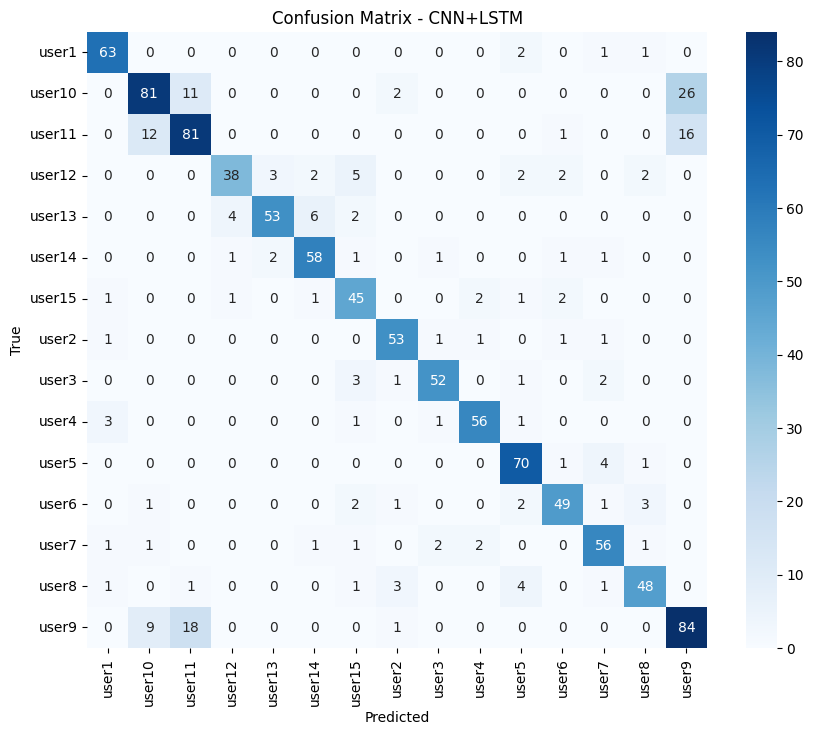

Classification Report - CNN+LSTM
              precision    recall  f1-score   support

       user1       0.90      0.94      0.92        67
      user10       0.78      0.68      0.72       120
      user11       0.73      0.74      0.73       110
      user12       0.86      0.70      0.78        54
      user13       0.91      0.82      0.86        65
      user14       0.85      0.89      0.87        65
      user15       0.74      0.85      0.79        53
       user2       0.87      0.91      0.89        58
       user3       0.91      0.88      0.90        59
       user4       0.92      0.90      0.91        62
       user5       0.84      0.92      0.88        76
       user6       0.86      0.83      0.84        59
       user7       0.84      0.86      0.85        65
       user8       0.86      0.81      0.83        59
       user9       0.67      0.75      0.71       112

    accuracy                           0.82      1084
   macro avg       0.84      0.83      0.83    

In [18]:
# Confusion matrix for CNN+LSTM with fixed class names
conf_matrix_cnn_lstm = confusion_matrix(y_test, y_pred_classes_cnn_lstm)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_cnn_lstm, annot=True, cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - CNN+LSTM')
plt.show()

# Classification report for CNN+LSTM
print("Classification Report - CNN+LSTM")
print(classification_report(y_test, y_pred_classes_cnn_lstm, target_names=label_encoder.classes_))

# Print model summary to see the number of parameters
model_cnn_lstm.summary()
